<a href="https://colab.research.google.com/github/rahiakela/hands-on-machine-learning-with-scikit-learn-keras-and-tensorflow/blob/15-processing-sequences-using-RNNs-CNNs/4_forecasting_time_series_tackling_short_term_memory_problem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tackling the Short-Term Memory Problem

Due to the transformations that the data goes through when traversing an RNN, some information is lost at each time step. After a while, the RNN’s state contains virtually no trace of the first inputs. This can be a show-stopper. 

Imagine Dory the fish 6 trying to translate a long sentence; by the time she’s finished reading it, she has no clue how it started.

To tackle this problem, various types of cells with long-term memory have been introduced. They have proven so successful that the basic cells are not used much anymore. Let’s first look at the most popular of these long-term memory cells: the LSTM cell.

## Setup

In [1]:
import sys
assert sys.version_info >= (3, 5)  # Python ≥3.5 is required

import sklearn 
assert sklearn.__version__ >= "0.20"  # Scikit-Learn ≥0.20 is required

# %tensorflow_version only exists in Colab.
try:
  %tensorflow_version 2.x
  IS_COLAB = True
except Exception:
  IS_COLAB = False
  pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= '2.0'

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

TensorFlow 2.x selected.


## Generate the Dataset

For simplicity, we are using a time series generated by the generate_time_series() function.

In [0]:
def generate_time_series(batch_size, n_steps):
  freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
  time = np.linspace(0, 1, n_steps)

  series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))      # wave 1
  series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20))     # + wave 2
  series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)       # + noise

  return series[..., np.newaxis].astype(np.float32)

This function creates as many time series as requested (via the batch_size argument), each of length n_steps , and there is just one value per time step in each series (i.e., all series are univariate). The function returns a NumPy array of shape [ batch size , time steps , 1], where each series is the sum of two sine waves of fixed amplitudes but random frequencies and phases, plus a bit of noise.

When dealing with time series (and other types of sequences such as sentences), the input features are generally represented as 3D arrays of shape [ batch size , time steps , dimensionality ], where dimensionality is 1 for univariate time series and more for multivariate time series.

Now let’s create a training set, a validation set, and a test set.

In [0]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 1)

X_train, y_train = series[:7000, : n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, n_steps], series[9000:, -1]

In [4]:
X_train.shape, y_train.shape

((7000, 50, 1), (7000, 1))

Since we want to forecast a single value for each series, the targets are column vectors (e.g., y_train has a shape of [7000, 1]).

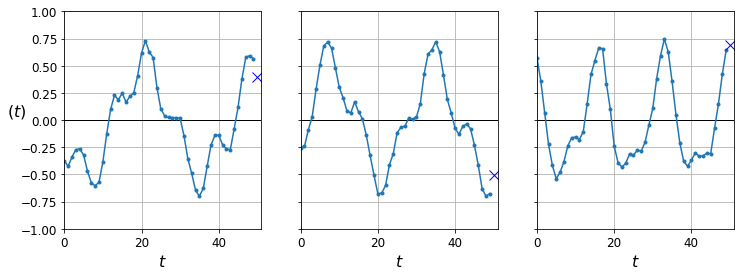

In [5]:
def plot_series(series, y=None, y_pred=None, x_label='$t$', y_label='$x(t)$'):
  plt.plot(series, '.-')

  if y is not None:
    plt.plot(n_steps, y, 'bx', markersize=10)
  if y_pred is not None:
    plt.plot(n_steps, y_pred , 'ro')
  plt.grid(True)

  if x_label:
    plt.xlabel(x_label, fontsize=16)
  if y_label:
    plt.ylabel(y_label, fontsize=16, rotation=0)

  plt.hlines(0, 0, 100, linewidth=1)
  plt.axis([0, n_steps + 1, -1, 1])

fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
  plt.sca(axes[col])
  plot_series(X_valid[col, :, 0], y_valid[col, 0], y_label=('$(t)$' if col==0 else None))

plt.show()

## Baseline Metrics

Before we start using RNNs, it is often a good idea to have a few baseline metrics, or else we may end up thinking our model works great when in fact it is doing worse than basic models.

For example, the simplest approach is to predict the last value in each series. This is called naive forecasting , and it is sometimes surprisingly difficult to outperform. In this case, it gives us a mean squared error of about 0.020:

In [6]:
y_pred = X_valid[:, -1]
np.mean(keras.losses.mean_absolute_error(y_valid, y_pred))

0.11627829

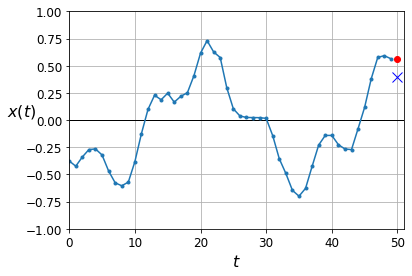

In [7]:
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

Another simple approach is to use a fully connected network. Since it expects a flat list of features for each input, we need to add a Flatten layer. 

Let’s just use a simple Linear Regression model so that each prediction will be a linear combination of the values in the time series:

In [8]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(1)                           
])

model.compile(loss='mse', optimizer='adam')
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 3s 367us/sample - loss: 0.1004 - val_loss: 0.0559
Epoch 2/20
7000/7000 [==============================] - 1s 87us/sample - loss: 0.0386 - val_loss: 0.0269
Epoch 3/20
7000/7000 [==============================] - 1s 91us/sample - loss: 0.0205 - val_loss: 0.0162
Epoch 4/20
7000/7000 [==============================] - 1s 86us/sample - loss: 0.0133 - val_loss: 0.0118
Epoch 5/20
7000/7000 [==============================] - 1s 92us/sample - loss: 0.0104 - val_loss: 0.0098
Epoch 6/20
7000/7000 [==============================] - 1s 95us/sample - loss: 0.0089 - val_loss: 0.0087
Epoch 7/20
7000/7000 [==============================] - 1s 99us/sample - loss: 0.0080 - val_loss: 0.0078
Epoch 8/20
7000/7000 [==============================] - 1s 87us/sample - loss: 0.0073 - val_loss: 0.0071
Epoch 9/20
7000/7000 [==============================] - 1s 82us/sample - loss: 0.0066 - val_loss: 0.0065
Epoch 

In [9]:
model.evaluate(X_valid, y_valid, verbose=0)

0.004145486194640398

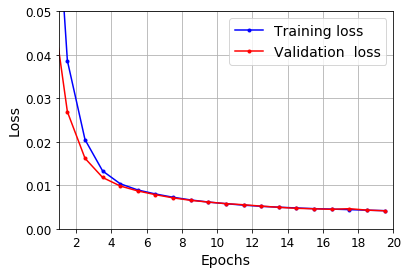

In [10]:
def plot_learning_curves(loss, val_loss):
  plt.plot(np.arange(len(loss)) + 0.5, loss, 'b.-', label='Training loss')
  plt.plot(np.arange(len(val_loss)) + 0.5, val_loss, 'r.-', label='Validation  loss')

  plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
  plt.axis([1, 20, 0, 0.05])
  plt.legend(fontsize=14)
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.grid(True)

plot_learning_curves(history.history['loss'], history.history['val_loss'])
plt.show()

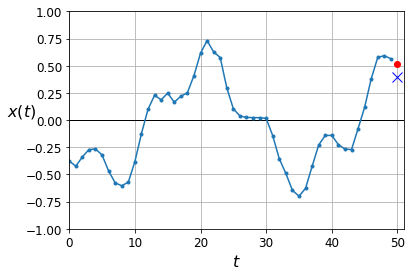

In [11]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

we get an MSE of about 0.004. That’s much better than the naive approach!

In [0]:
np.random.seed(43)  # not 42, as it would give the first series in the train set

series = generate_time_series(1, n_steps + 10)
X_new, Y_new = series[:, :n_steps], series[:, n_steps:]
X = X_new

for step_ahead in range(10):
  y_pred_one = model.predict(X[:, step_ahead:])[:, np.newaxis, :]
  X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:]

In [13]:
Y_pred.shape

(1, 10, 1)

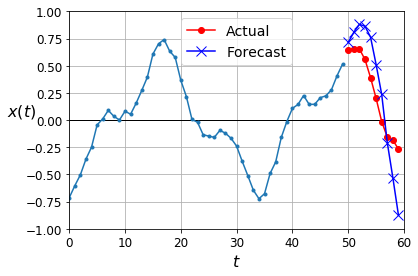

In [14]:
def plot_multiple_forecasts(X, Y, Y_pred):
  n_steps = X.shape[1]
  ahead = Y.shape[1]
  plot_series(X[0, :, 0])
  plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], 'ro-', label='Actual')
  plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], 'bx-', label='Forecast', markersize=10)
  plt.axis([0, n_steps + ahead, -1, 1])
  plt.legend(fontsize=14)

plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

In [0]:
def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

## LSTM cells

If you consider the LSTM cell as a black box, it can be used very much like a basic cell, except it will perform much better; training will converge faster, and it will detect long-term dependencies in the data. In Keras, you can simply use the LSTM layer instead of the SimpleRNN layer:

<img src='https://github.com/rahiakela/img-repo/blob/master/hands-on-machine-learning-keras-tensorflow/lstm-cell.png?raw=1' width='800'/>

In [0]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train = series[:7000, :n_steps]
X_valid = series[7000:9000, :n_steps]
X_test = series[9000:, :n_steps]
Y = np.empty((10000, n_steps, 10))
for step_ahead in range(1, 10 + 1):
    Y[..., step_ahead - 1] = series[..., step_ahead:step_ahead + n_steps, 0]
Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test = Y[9000:]

In [17]:
X_train.shape, Y_train.shape

((7000, 50, 1), (7000, 50, 10))

In [18]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
   keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]),
   keras.layers.LSTM(20, return_sequences=True),
   keras.layers.TimeDistributed(keras.layers.Dense(10))                              
])

model.compile(loss='mse', optimizer='adam', metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20, validation_data=(X_valid, Y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 10s 1ms/sample - loss: 0.0760 - last_time_step_mse: 0.0615 - val_loss: 0.0554 - val_last_time_step_mse: 0.0372
Epoch 2/20
7000/7000 [==============================] - 2s 323us/sample - loss: 0.0480 - last_time_step_mse: 0.0281 - val_loss: 0.0423 - val_last_time_step_mse: 0.0211
Epoch 3/20
7000/7000 [==============================] - 2s 332us/sample - loss: 0.0390 - last_time_step_mse: 0.0182 - val_loss: 0.0371 - val_last_time_step_mse: 0.0164
Epoch 4/20
7000/7000 [==============================] - 2s 306us/sample - loss: 0.0350 - last_time_step_mse: 0.0151 - val_loss: 0.0335 - val_last_time_step_mse: 0.0143
Epoch 5/20
7000/7000 [==============================] - 2s 326us/sample - loss: 0.0325 - last_time_step_mse: 0.0136 - val_loss: 0.0314 - val_last_time_step_mse: 0.0124
Epoch 6/20
7000/7000 [==============================] - 2s 323us/sample - loss: 0.0308 - last_time_step_mse: 0.01

In [19]:
model.evaluate(X_valid, Y_valid)

2000/2000 [==============================] - 0s 126us/sample - loss: 0.0240 - last_time_step_mse: 0.0086


[0.024016654670238495, 0.008551414]

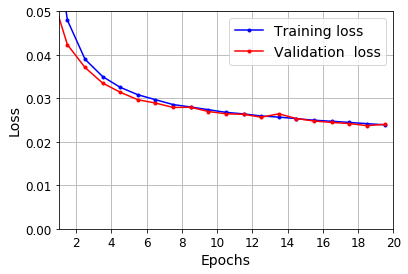

In [20]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [0]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

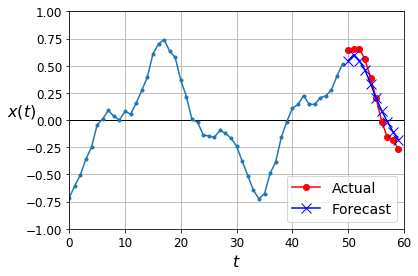

In [22]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

Alternatively, you could use the general-purpose keras.layers.RNN layer, giving it an LSTMCell as an argument:

In [23]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
   keras.layers.RNN(keras.layers.LSTMCell(20), return_sequences=True, input_shape=[None, 1]),
   keras.layers.RNN(keras.layers.LSTMCell(20), return_sequences=True),
   keras.layers.TimeDistributed(keras.layers.Dense(10))                              
])

model.compile(loss='mse', optimizer='adam', metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20, validation_data=(X_valid, Y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 23s 3ms/sample - loss: 0.0760 - last_time_step_mse: 0.0615 - val_loss: 0.0554 - val_last_time_step_mse: 0.0372
Epoch 2/20
7000/7000 [==============================] - 21s 3ms/sample - loss: 0.0480 - last_time_step_mse: 0.0281 - val_loss: 0.0423 - val_last_time_step_mse: 0.0211
Epoch 3/20
7000/7000 [==============================] - 21s 3ms/sample - loss: 0.0390 - last_time_step_mse: 0.0182 - val_loss: 0.0371 - val_last_time_step_mse: 0.0164
Epoch 4/20
7000/7000 [==============================] - 22s 3ms/sample - loss: 0.0350 - last_time_step_mse: 0.0151 - val_loss: 0.0335 - val_last_time_step_mse: 0.0143
Epoch 5/20
7000/7000 [==============================] - 22s 3ms/sample - loss: 0.0325 - last_time_step_mse: 0.0136 - val_loss: 0.0314 - val_last_time_step_mse: 0.0124
Epoch 6/20
7000/7000 [==============================] - 21s 3ms/sample - loss: 0.0308 - last_time_step_mse: 0.0123 - 

In [24]:
model.evaluate(X_valid, Y_valid)

2000/2000 [==============================] - 1s 557us/sample - loss: 0.0240 - last_time_step_mse: 0.0086


[0.024016652554273606, 0.008551413]

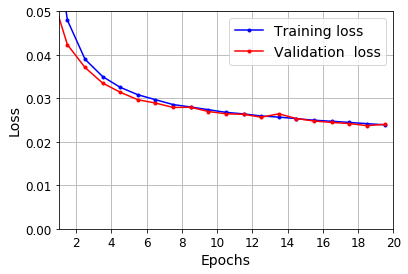

In [25]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [0]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

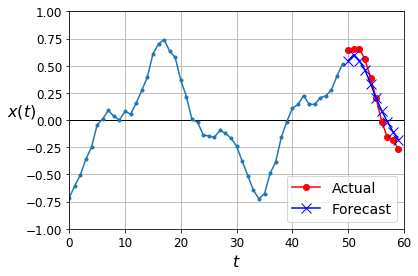

In [27]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

However, the LSTM layer uses an optimized implementation when running on a GPU, so in general it is preferable to use it (the RNN layer is mostly useful when you define custom cells, as we did earlier).

## GRU cells

The GRU cell is a simplified version of the LSTM cell, and it seems to perform just as well 12 (which explains its growing popularity).

<img src='https://github.com/rahiakela/img-repo/blob/master/hands-on-machine-learning-keras-tensorflow/gru-cell.png?raw=1' width='800'/>

In [28]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
   keras.layers.GRU(20, return_sequences=True, input_shape=[None, 1]),
   keras.layers.GRU(20, return_sequences=True),
   keras.layers.TimeDistributed(keras.layers.Dense(10))                             
])

model.compile(loss='mse', optimizer='adam', metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20, validation_data=(X_valid, Y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 4s 633us/sample - loss: 0.0742 - last_time_step_mse: 0.0663 - val_loss: 0.0523 - val_last_time_step_mse: 0.0421
Epoch 2/20
7000/7000 [==============================] - 2s 301us/sample - loss: 0.0476 - last_time_step_mse: 0.0367 - val_loss: 0.0441 - val_last_time_step_mse: 0.0327
Epoch 3/20
7000/7000 [==============================] - 2s 301us/sample - loss: 0.0418 - last_time_step_mse: 0.0305 - val_loss: 0.0391 - val_last_time_step_mse: 0.0271
Epoch 4/20
7000/7000 [==============================] - 2s 313us/sample - loss: 0.0373 - last_time_step_mse: 0.0249 - val_loss: 0.0343 - val_last_time_step_mse: 0.0205
Epoch 5/20
7000/7000 [==============================] - 2s 303us/sample - loss: 0.0327 - last_time_step_mse: 0.0179 - val_loss: 0.0313 - val_last_time_step_mse: 0.0158
Epoch 6/20
7000/7000 [==============================] - 2s 308us/sample - loss: 0.0308 - last_time_step_mse: 0.0

In [29]:
model.evaluate(X_valid, Y_valid)

2000/2000 [==============================] - 0s 128us/sample - loss: 0.0241 - last_time_step_mse: 0.0103


[0.02407100686430931, 0.010298318]

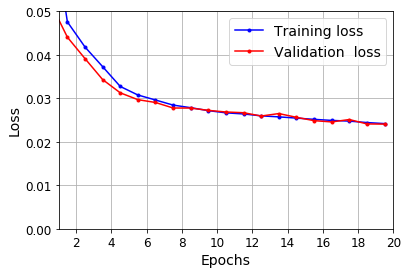

In [30]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [0]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

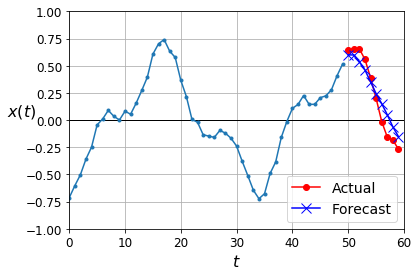

In [32]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

LSTM and GRU cells are one of the main reasons behind the success of RNNs. Yet while they can tackle much longer sequences than simple RNNs, they still have a fairly limited short-term memory, and they have a hard time learning long-term patterns in sequences of 100 time steps or more, such as audio samples, long time series, or long sentences. 

One way to solve this is to shorten the input sequences, for example using 1D convolutional layers.

## Using One-Dimensional Convolutional Layers to Process Sequences

A 2D convolutional layer works by sliding several fairly small kernels (or filters) across an image, producing multiple 2D feature maps (one per kernel). 

Similarly, a 1D convolutional layer slides several kernels across a sequence, producing a 1D feature map per kernel. Each kernel will learn to detect a single very short sequential pattern (no longer than the kernel size). 

If you use 10 kernels, then the layer’s output will be composed of 10 1-dimensional sequences (all of the same length), or equivalently you can view this output as a single 10-dimensional sequence. This means that you can build a neural network composed of a mix of recurrent layers and 1D convolutional layers (or even 1D pooling layers). If you use a 1D convolutional layer with a stride of 1 and "same" padding, then the output sequence will have the same length as the input sequence. But if you use "valid" padding or a stride greater than 1, then the output sequence will be shorter than the input sequence, so make sure you adjust the targets accordingly. 

For example, the following model is the same as earlier, except it starts with a 1D convolutional layer that downsamples the input sequence by a factor of 2, using a stride of 2. The kernel size is larger than the stride, so all inputs will be used to compute the layer’s output, and therefore the model can learn to preserve the useful information, dropping only the unimportant details. By shortening the sequences, the convolutional layer may help the GRU layers detect longer patterns. Note that we must also crop off the first three time steps in the targets (since the kernel’s size is 4, the first output of the convolutional layer will be based on the input time steps 0 to 3), and downsample the targets by a factor of 2.

<img src='https://github.com/rahiakela/img-repo/blob/master/hands-on-machine-learning-keras-tensorflow/1-d-conv-on-seq.png?raw=1' width='800'/>

In [33]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
   keras.layers.Conv1D(filters=20, kernel_size=4, strides=2, padding='valid', input_shape=[None, 1]),
   keras.layers.GRU(20, return_sequences=True),
   keras.layers.GRU(20, return_sequences=True),
   keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss='mse', optimizer='adam', metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train[:, 3::2], epochs=20, validation_data=(X_valid, Y_valid[:, 3::2]))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 4s 611us/sample - loss: 0.0683 - last_time_step_mse: 0.0605 - val_loss: 0.0482 - val_last_time_step_mse: 0.0405
Epoch 2/20
7000/7000 [==============================] - 2s 241us/sample - loss: 0.0416 - last_time_step_mse: 0.0342 - val_loss: 0.0368 - val_last_time_step_mse: 0.0283
Epoch 3/20
7000/7000 [==============================] - 2s 244us/sample - loss: 0.0334 - last_time_step_mse: 0.0251 - val_loss: 0.0307 - val_last_time_step_mse: 0.0220
Epoch 4/20
7000/7000 [==============================] - 2s 247us/sample - loss: 0.0273 - last_time_step_mse: 0.0172 - val_loss: 0.0251 - val_last_time_step_mse: 0.0141
Epoch 5/20
7000/7000 [==============================] - 2s 258us/sample - loss: 0.0243 - last_time_step_mse: 0.0134 - val_loss: 0.0238 - val_last_time_step_mse: 0.0128
Epoch 6/20
7000/7000 [==============================] - 2s 249us/sample - loss: 0.0230 - last_time_step_mse: 0.0

In [35]:
model.evaluate(X_valid, Y_valid[:, 3::2])

2000/2000 [==============================] - 0s 128us/sample - loss: 0.0173 - last_time_step_mse: 0.0067


[0.017292515411973, 0.0067232875]

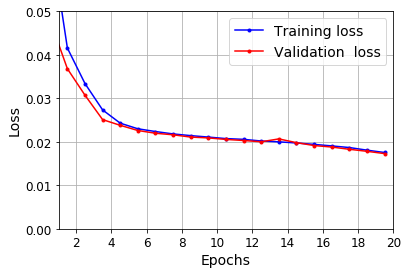

In [36]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [0]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

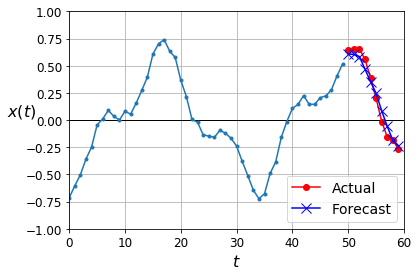

In [38]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

As you will see and find that it is the best model so far. The convolutional layer really helps. In fact, it is actually possible to use only 1D convolutional layers and drop the recurrent layers entirely!

## WaveNet

WaveNet architecture stack 1D convolutional layers, doubling the dilation rate (how spread apart each neuron’s inputs are) at every layer: the first convolutional layer gets a glimpse of just two time steps at a time, while the next one sees four time steps (its receptive field is four time steps long), the next one sees eight time steps, and so on.

<img src='https://github.com/rahiakela/img-repo/blob/master/hands-on-machine-learning-keras-tensorflow/wave-net-architecture.png?raw=1' width='800'/>

This way, the lower layers learn short-term patterns, while the higher layers learn long-term patterns. Thanks to the doubling dilation rate, the network can process extremely large sequences very efficiently.

validation_data=(X_valid, Y_valid)) This Sequential model starts with an explicit input layer (this is simpler than trying to set input_shape only on the first layer), then continues with a 1D convolutional layer using "causal" padding: this ensures that the convolutional layer does not peek into the future when making predictions (it is equivalent to padding the inputs with the right amount of zeros on the left and using "valid" padding).

We then add similar pairs of layers using growing dilation rates: 1, 2, 4, 8, and again 1, 2, 4, 8. Finally, we add the output layer: a convolutional layer with 10 filters of size 1 and without any activation function. Thanks to the padding layers, every convolutional layer outputs a sequence of the same length as the input sequences, so the targets we use during training can be the full sequences: no need to crop them or downsample them.



In [39]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))

for rate in (1, 2, 4, 8) * 2:
  model.add(keras.layers.Conv1D(filters=20, kernel_size=2, padding='causal', activation='relu', dilation_rate=rate))

model.add(keras.layers.Conv1D(filters=10, kernel_size=1))

model.compile(loss='mse', optimizer='adam', metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20, validation_data=(X_valid, Y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 3s 405us/sample - loss: 0.0684 - last_time_step_mse: 0.0550 - val_loss: 0.0385 - val_last_time_step_mse: 0.0249
Epoch 2/20
7000/7000 [==============================] - 1s 214us/sample - loss: 0.0341 - last_time_step_mse: 0.0215 - val_loss: 0.0306 - val_last_time_step_mse: 0.0183
Epoch 3/20
7000/7000 [==============================] - 1s 200us/sample - loss: 0.0292 - last_time_step_mse: 0.0173 - val_loss: 0.0274 - val_last_time_step_mse: 0.0156
Epoch 4/20
7000/7000 [==============================] - 1s 213us/sample - loss: 0.0269 - last_time_step_mse: 0.0152 - val_loss: 0.0263 - val_last_time_step_mse: 0.0147
Epoch 5/20
7000/7000 [==============================] - 1s 203us/sample - loss: 0.0255 - last_time_step_mse: 0.0137 - val_loss: 0.0248 - val_last_time_step_mse: 0.0131
Epoch 6/20
7000/7000 [==============================] - 1s 204us/sample - loss: 0.0245 - last_time_step_mse: 0.0

In [44]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, None, 20)          60        
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 20)          820       
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 20)          820       
_________________________________________________________________
conv1d_4 (Conv1D)            (None, None, 20)          820       
_________________________________________________________________
conv1d_5 (Conv1D)            (None, None, 20)          820       
_________________________________________________________________
conv1d_6 (Conv1D)            (None, None, 20)          820       
_________________________________________________________________
conv1d_7 (Conv1D)            (None, None, 20)         

In [45]:
model.evaluate(X_valid, Y_valid)

2000/2000 [==============================] - 0s 112us/sample - loss: 0.0204 - last_time_step_mse: 0.0086


[0.02042392697930336, 0.0086391065]

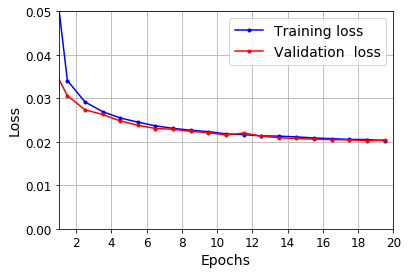

In [46]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [0]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

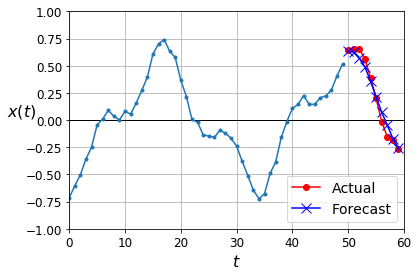

In [48]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

The last two models offer the best performance so far in forecasting our time series! 

In the WaveNet paper, the authors achieved state-of-the-art performance on various audio tasks (hence the name of the architecture), including text-to-speech tasks, producing incredibly realistic voices across several languages. They also used the model to generate music, one audio sample at a time.

This feat is all the more impressive when you realize that a single second of audio can contain tens of thousands of time steps—even LSTMs and GRUs cannot handle such long sequences.